# Project 4 WSDM - KKBox's Music Recommendation Challenge

Team Members: Jian Lu(20003617)  Peijin He(18038703)  Chang Liu (19038848)

## Table of Content 

<br> 1. Introduction
<br> 2.Abstract
<br> 3.Tables
<br> 4.EDA & Data Exploring
        * Missing value ratio
        * Target distribution
        * Source System Tab Chart
        * Source Screen Name Chart
        * Source Type Chart
        * Song Language Distribution
        * Songs Genre Distribution
        * Repeat Songs According to genre
        * Top 20 Repeat Singer
        * The Most Repeat Artists
        * Repeat Songs According To City
        * Gender Distribution
        * Repeat Gender Distribution
        * Repeat According to Age Group
        * Repeat According to Membership Duration
  
<br> 5. Merge and read data
<br> 6. Process Data
    * Process null data
    * Add Gener_count column
    * Add repeat_percentage column
    * Data mergeing and add composer_count feature
    * Replace string value with numbers , add lyricist_count and validity_days feature
    * Transform isrc column to year 
    * Process data types and create age groups

<br> 7. Algotirhm part
    
    * Models
        * Naive Bayes
        * Random Forest
        * Ada Boost
        * Light GBM

<br> 8. Conclusion
    

## Abstract 

In this project, the first part is data processing, fill the null values with mode, median, mean or unknown type. Then, for getting a better result, we added features like validity_days, repeat_percentage.. and transform the values in age group, genre_id… Next, we compared the results of several common algorithm.

## Introduction

<br> With the development of music diversity, people have their own preferences and favorite songs, singers. KKBOX has an interesting study that predicts whether users will continue to listen to the same song after hearing it once for a month, i.e. the repetition rate of the song. However, how to study this phenomenon and how to use different features and different prediction models to influence this result is worth exploring.

### Tables

#### train.csv

* msno: user id
* song_id: song id
* source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* source_screen_name: name of the layout a user sees.
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc.
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

#### test.csv

* id: row id (will be used for submission)
* msno: user id
* song_id: song id
* source_system_tab: the name of the tab where the event was triggered. System tabs are used to categorize KKBOX mobile apps functions. For example, tab my library contains functions to manipulate the local storage, and tab search contains functions relating to search.
* source_screen_name: name of the layout a user sees.
* source_type: an entry point a user first plays music on mobile apps. An entry point could be album, online-playlist, song .. etc

#### sample_submission.csv
sample submission file in the format that we expect you to submit

* id: same as id in test.csv
* target: this is the target variable. target=1 means there are recurring listening event(s) triggered within a month after the user’s very first observable listening event, target=0 otherwise .

#### songs.csv

The songs. Note that data is in unicode.

* song_id
* song_length: in ms
* genre_ids: genre category. Some songs have multiple genres and they are separated by |
* artist_name
* composer
* lyricist
* language

#### members.csv

user information.

* msno
* city
* bd: age. Note: this column has outlier values, please use your judgement.
* gender
* registered_via: registration method
* registration_init_time: format %Y%m%d
* expiration_date: format %Y%m%d

#### song_extra_info.csv

* song_id
* song name - the name of the song.
* isrc - International Standard Recording Code, theoretically can be used as an identity of a song. However, what worth to note is, ISRCs generated from providers have not been officially verified; therefore the information in ISRC, such as country code and reference year, can be misleading/incorrect. Multiple songs could share one ISRC since a single recording could be re-published several times.

## EDA & Data Exploring

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import warnings

warnings.simplefilter("ignore")

In [2]:
train = pd.read_csv('./train.csv',engine='c')
test = pd.read_csv('./test.csv',engine='c')
members = pd.read_csv("members.csv",parse_dates=["registration_init_time","expiration_date"],engine='c')
songs = pd.read_csv('./songs.csv',engine='c')
song_extra_info = pd.read_csv('./song_extra_info.csv',engine='c')

In [3]:
plt.rcParams["figure.figsize"] = [6, 5]

In [4]:
train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
msno                  object
song_id               object
source_system_tab     object
source_screen_name    object
source_type           object
target                int64
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [6]:
test.head()

,id,msno,song_id,source_system_tab,source_screen_name,source_type
0,0,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,WmHKgKMlp1lQMecNdNvDMkvIycZYHnFwDT72I5sIssc=,my library,Local playlist more,local-library
1,1,V8ruy7SGk7tDm3zA51DPpn6qutt+vmKMBKa21dp54uM=,y/rsZ9DC7FwK5F2PK2D5mj+aOBUJAjuu3dZ14NgE0vM=,my library,Local playlist more,local-library
2,2,/uQAlrAkaczV+nWCd2sPF2ekvXPRipV7q0l+gbLuxjw=,8eZLFOdGVdXBSqoAv5nsLigeH2BvKXzTQYtUM53I0k4=,discover,NaN,song-based-playlist
3,3,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=,radio,Radio,radio
4,4,1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=,MKVMpslKcQhMaFEgcEQhEfi5+RZhMYlU3eRDpySrH8Y=,radio,Radio,radio


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680047 entries, 0 to 680046
Data columns (total 6 columns):
id                    680047 non-null int64
msno                  680047 non-null object
song_id               680047 non-null object
source_system_tab     677741 non-null object
source_screen_name    639769 non-null object
source_type           678046 non-null object
dtypes: int64(1), object(5)
memory usage: 31.1+ MB


In [8]:
songs.head()

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640.0,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328.0,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781.0,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554.0,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329.0,726,貴族精選,Traditional,Traditional,52.0


In [9]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774026 entries, 0 to 774025
Data columns (total 7 columns):
song_id        774026 non-null object
song_length    774025 non-null float64
genre_ids      748678 non-null object
artist_name    774025 non-null object
composer       424528 non-null object
lyricist       148905 non-null object
language       774024 non-null float64
dtypes: float64(2), object(5)
memory usage: 41.3+ MB


In [10]:
song_extra_info.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [11]:
song_extra_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070989 entries, 0 to 1070988
Data columns (total 3 columns):
song_id    1070989 non-null object
name       1070986 non-null object
isrc       988876 non-null object
dtypes: object(3)
memory usage: 24.5+ MB


In [12]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [13]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13


In [14]:
pd.DataFrame(train.isnull().sum().apply(lambda x: x/train.shape[0]), columns=['missing value radio'])

,missing value radio
msno,0.000000
song_id,0.000000
source_system_tab,0.003368
source_screen_name,0.056226
source_type,0.002920
target,0.000000


### Missing value ratio

Text(0.5, 1.0, 'Missing value ratio')

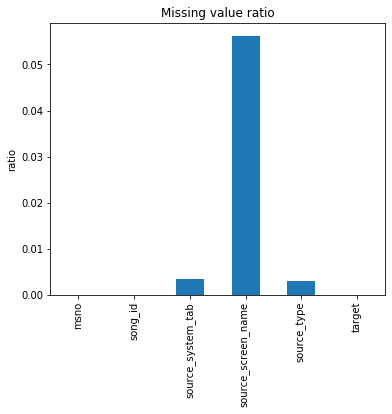

In [15]:
train.isnull().sum().apply(lambda x: x/train.shape[0]).plot.bar()
plt.ylabel('ratio')
plt.title('Missing value ratio')

There are a lot of null values in the dataset.

### Target distribution

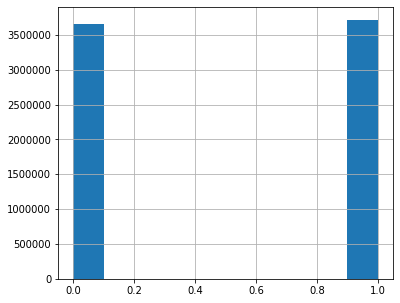

In [16]:
train.target.hist()

The target has an average distribution, and only 0 and 1 are inside the target.

### Source System Tab Chart

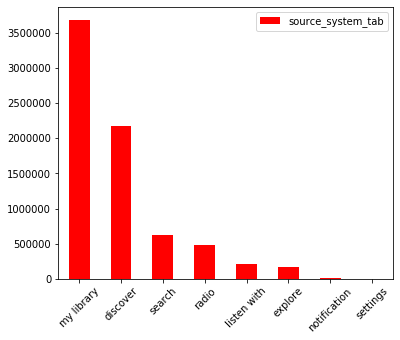

In [17]:
source_system_tab_chart = train.source_system_tab.value_counts().plot.bar(color='red')
source_system_tab_chart.set_xticklabels(source_system_tab_chart.get_xticklabels(),rotation=45)
source_system_tab_chart.legend()

source_system_tab shows where user most likely to start their music journey from the main page

### Source Screen Name Chart

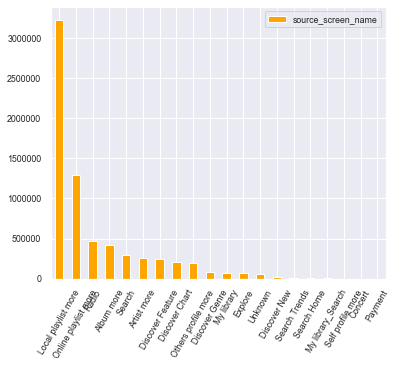

In [18]:
sns.set(font_scale=0.8)
source_screen_name_chart = train.source_screen_name.value_counts().plot.bar(color='orange')
source_screen_name_chart.set_xticklabels(source_screen_name_chart.get_xticklabels(),rotation=60)
source_screen_name_chart.legend()

### Source Type Chart

[Text(0, 0, 'local-library'),
 Text(0, 0, 'online-playlist'),
 Text(0, 0, 'local-playlist'),
 Text(0, 0, 'radio'),
 Text(0, 0, 'album'),
 Text(0, 0, 'top-hits-for-artist'),
 Text(0, 0, 'song'),
 Text(0, 0, 'song-based-playlist'),
 Text(0, 0, 'listen-with'),
 Text(0, 0, 'topic-article-playlist'),
 Text(0, 0, 'artist'),
 Text(0, 0, 'my-daily-playlist')]

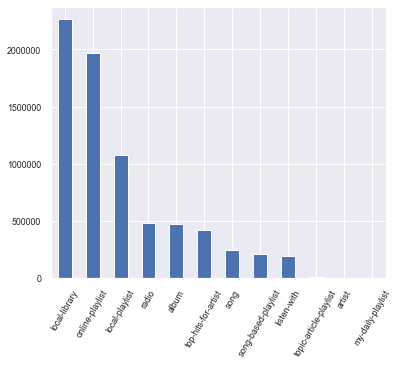

In [19]:
source_type_chart = train.source_type.value_counts().plot.bar()
source_type_chart.set_xticklabels(source_type_chart.get_xticklabels(),rotation=60)

source_screen_name_chart and source_type_chart shows where user most likely to start their music journey from the user personal page

### Song Language Distribution

Text(0.5, 1.0, 'Songs According to language')

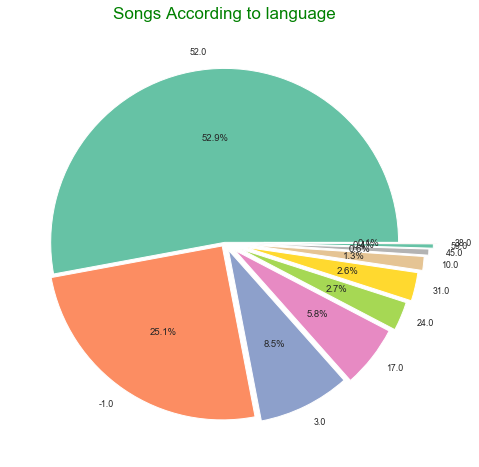

In [20]:
labels=songs.language.value_counts().index
explode = [0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225]
sizes = songs.language.value_counts().values
plt.figure(figsize = (8,8))
plt.pie(sizes, explode=explode,labels=labels, colors=sns.color_palette('Set2'), autopct='%1.1f%%')
plt.title('Songs According to language',fontsize = 17,color = 'green')

 From this pie chart, it can be seen that the 52.0 (English) is the most common language and followed by -1.0 (Others), then 3.0(Chinese).

### Songs Genre Distribution

Text(0.5, 1.0, 'Songs According to genre')

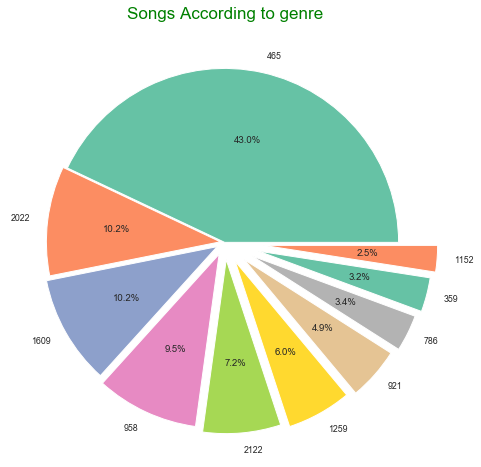

In [21]:
labels=songs.genre_ids.value_counts()[:10].index
explode = [0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225]
sizes =songs.genre_ids.value_counts()[:10].values
plt.figure(figsize = (8,8))
plt.pie(sizes, explode=explode,labels=labels, colors=sns.color_palette('Set2'), autopct='%1.1f%%')
plt.title('Songs According to genre',fontsize = 17,color = 'green')

The type of songs is usually important for a person who loves to listen to the songs. For this part, it shows that the most popular genre of songs is 456 which is 37.3 percent.

### Repeat Songs According to genre

Text(0.5, 1.0, 'Repeat Songs According to genre')

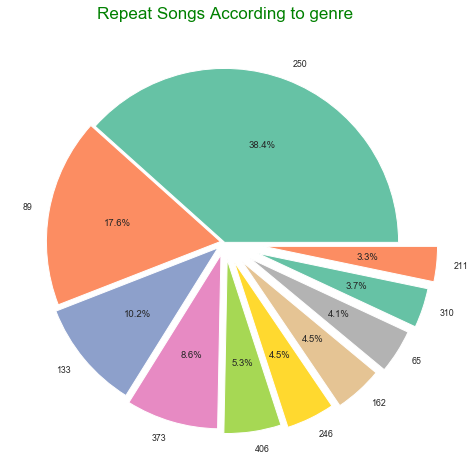

In [22]:
repeats=train[train.target==1]
song_repeats=repeats.groupby('song_id',as_index=False).msno.count()
song_repeats.columns=['song_id','count']
song_repeats=pd.DataFrame(song_repeats).merge(songs,left_on='song_id',right_on='song_id')
genre_repeats = song_repeats.groupby('genre_ids', as_index=False).song_id.count()
genre_repeats.columns=['genre_ids','gcount']
genre_repeats=genre_repeats.sort_values(by="gcount" , ascending=False)
labels=genre_repeats.genre_ids[:10].index
explode = [0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225]
sizes =genre_repeats.gcount.value_counts()[:10].values
plt.figure(figsize = (8,8))
plt.pie(sizes, explode=explode,labels=labels, colors=sns.color_palette('Set2'), autopct='%1.1f%%')
plt.title('Repeat Songs According to genre',fontsize = 17,color = 'green')

Although genre 465 is the largest among the whole genre group, in the repeat group, genre 279 need to be weighted more, one third of the repeat songs are genre 279. 

In [23]:
song_repeats.head()

,song_id,count,song_length,genre_ids,artist_name,composer,lyricist,language
0,++7GdTgp8zbQLYOki7hVPEOHpu+KLZClsGrGiEuL2uI=,22,267075.0,458,袁詠琳 (Cindy Yen),Cindy袁詠琳,賴雅妍| 黃俊郎,3.0
1,++9CllWTafshZc7T8X7cvNfUxgDe0WYrJ3TOen026j4=,3,222632.0,423,Enrique Iglesias,Enrique Iglesias| Ray “El Ingeniero” Casillas|...,NaN,52.0
2,++9STZwz5v1kTToOlmexz9ZsuoghLuwY5lCQpa//lRs=,1,270837.0,1609,Various Artists,NaN,NaN,52.0
3,++A2uqzDg/vUWu0x/cBalbddrVIJXggKKgQCkEnXmkI=,3,224757.0,465,張蓉蓉,黃聰典,台灣阿典,10.0
4,++CfKs1t1wU1t0q0UxCdRqGoDpToqgMPmYytklaqo9o=,18,224574.0,465,JUNIEL,TWO FACE | 이상호 (Lee Sang Ho),한성호 (Han Sung Ho),31.0


In [24]:
singer_repeats=song_repeats.groupby('artist_name',as_index=False).song_id.count()
singer_repeats.columns=['artist_name','scount']
singer_repeats=singer_repeats.sort_values(by='scount' , ascending=False)
singer_repeats_top20 = singer_repeats.iloc[0:23,:]
#singer_repeats=pd.DataFrame(song_repeats).merge(songs,left_on='song_id',right_on='song_id')

### Top 20 Repeat Singer

In [25]:
singer_repeats_top20

,artist_name,scount
14818,Various Artists,6791
19178,証聲音樂圖書館 ECHO MUSIC,1793
19250,貴族精選,645
17238,張學友 (Jacky Cheung),547
19652,陳奕迅 (Eason Chan),537
19843,霹靂布袋戲劇集原聲帶,414
19424,鄧麗君 (Teresa Teng),384
16170,五月天 (Mayday),381
19005,蔡依林 (Jolin Tsai),325
9417,Michael Jackson,293


the list shows the most repeat singer in the repeat group, the first three are groups which contains multiple artists labels, for showing single singer's repeat situation, the three two will be dropped

### The Most Repeat Artists

In [26]:
sns.set(font='SimHei',font_scale=1.5) 

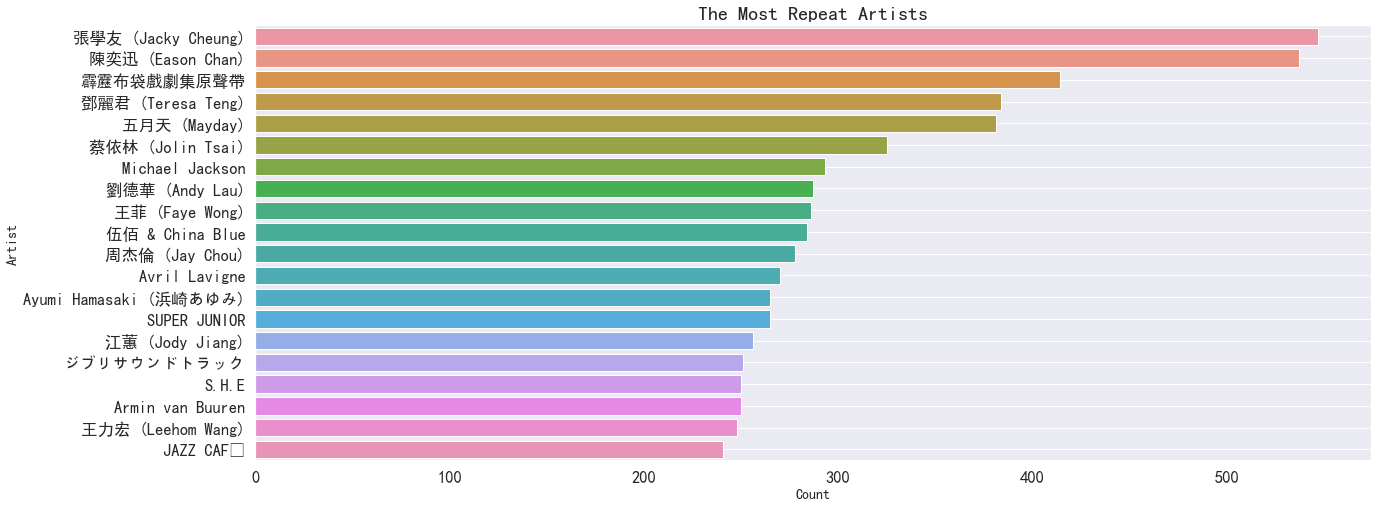

In [27]:
singer_repeats_top20 = singer_repeats_top20.iloc[3:23,:]
plt.figure(figsize=(20,8))
sns.barplot(y = singer_repeats_top20.artist_name, x = singer_repeats_top20.scount, orient='h')
plt.ylabel("Artist",fontsize=14)
plt.xlabel("Count",fontsize=14)
plt.title("The Most Repeat Artists",fontsize=20)
plt.grid()
plt.show()

Top singers are bound to have an impact on the goals we need, and the weight of these singers should be carefully considered

In [28]:
members_repeats=repeats.groupby('msno',as_index=False).song_id.count()
members_repeats.columns=['msno','count']
members_repeats.head()

,msno,count
0,++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sywtuU=,293
1,++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=,141
2,++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=,76
3,++xWL5Pbi2CpG4uUugigQahauM0J/sBIRloTNPBybIU=,1
4,+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=,82


In [29]:
members_repeats = pd.DataFrame(members_repeats).merge(members,left_on='msno',right_on='msno')
#members_repeats['member_days'] = (members_repeats['expiration_date'] - members_repeats['registration_init_time']).dt.days
#members_repeats.drop(["registration_init_time","expiration_date"],axis=1,inplace=True)
#members_repeats=members_repeats.sort_values(by='member_days' , ascending=False)

### Repeat Songs According To City

In [30]:
city_repeat=members_repeats.groupby('city',as_index=False).msno.count()
city_repeat.columns=['city','repeat_member']
city_repeat=city_repeat.sort_values(by='repeat_member' , ascending=False)

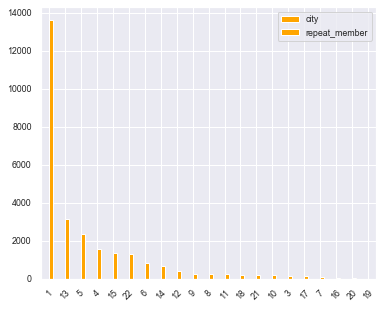

In [31]:
sns.set(font_scale=0.8)
city_repeat_chart = city_repeat.plot.bar(color='orange')
city_repeat_chart.set_xticklabels(city_repeat.city,rotation=45)
city_repeat_chart.legend()

As shown in the bar chart above, the user in city one has the most repeat times;

In [32]:
members_all=members.groupby('msno',as_index=False)
members_all = members.groupby('city',as_index=False).msno.count()
repeat_city_ratio = pd.DataFrame(city_repeat).merge(members_all,left_on='city',right_on='city')
repeat_city_ratio.columns=["city","repeat_member","all_member"]
repeat_city_ratio['ratio']= (repeat_city_ratio['repeat_member']/ repeat_city_ratio['all_member'])
repeat_city_ratio=repeat_city_ratio.sort_values(by='ratio' , ascending=False)

In [33]:
repeat_city_ratio

,city,repeat_member,all_member,ratio
20,19,11,11,1.000000
19,20,27,27,1.000000
7,14,658,708,0.929379
1,13,3144,3395,0.926068
16,17,137,152,0.901316
9,9,278,309,0.899676
4,15,1372,1525,0.899672
6,6,819,913,0.897043
13,21,191,213,0.896714
5,22,1315,1467,0.896387


From the table above we can see that although city 1 hase the most user , the recommend success rate rank is the last. The current method that kkbox use has a good performance in City like 13 , 22 and 4.

### Gender Distribution

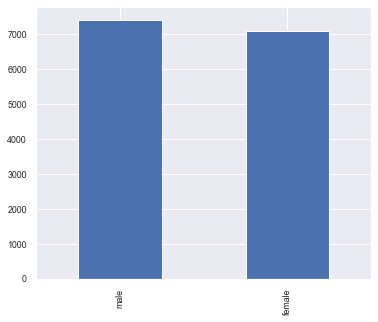

In [34]:
members.gender.value_counts().plot.bar()

### Repeat Gender Distribution

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002AB91C36B00>],
      dtype=object)

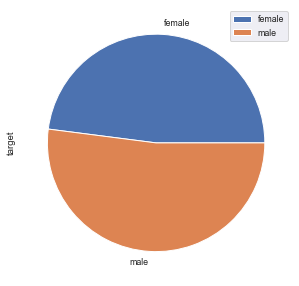

In [35]:
gender_repeat = train.merge(members, how='left', on='msno')
gender_repeat = gender_repeat.merge(songs, how='left', on='song_id')
gender_repeat[['gender', 'target']][gender_repeat.gender.notnull()].groupby('gender').count().plot.pie(subplots=True)

From the pie chart, the success rate of repeated listening to music in male is slightly higher than that in female. But according to the gender bar chart above,the number of male is more than female, in that way the rate of female and male repeat is a normal result. 

### Repeat According to Age Group

In [36]:
# split age group
gender_repeat = gender_repeat[(gender_repeat.bd > 0) & (gender_repeat.bd < 120)]
gender_repeat['bd_label'] = gender_repeat.bd.apply(lambda x: -1 if np.isnan(x) else x//20)

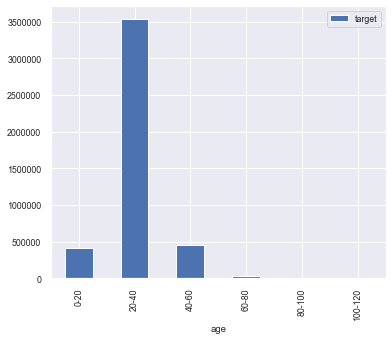

In [37]:
gender_repeat[['bd_label', 'target']][gender_repeat.bd.notnull()].groupby('bd_label').count().plot.bar()
plt.xlabel('age')
plt.xticks(ticks=range(6), labels=['0-20','20-40','40-60','60-80','80-100','100-120'])
plt.show()

age group of 20-40 hase the most repeat times

In [38]:
gender_repeat['member_days'] = gender_repeat.expiration_date-gender_repeat.registration_init_time
gender_repeat.member_days = gender_repeat.member_days.apply(lambda x: x.days)
gender_repeat['years_label'] = gender_repeat.member_days.apply(lambda x: x//365 if x >= 0 else 0)

In [39]:
gender_repeat.years_label.value_counts()

6     610730
2     551409
4     530408
5     482128
1     467963
3     445258
10    229984
7     223503
0     199311
9     192416
11    192355
8     155311
12     96923
13     56003
14      1120
Name: years_label, dtype: int64

### Repeat According to Membership Duration

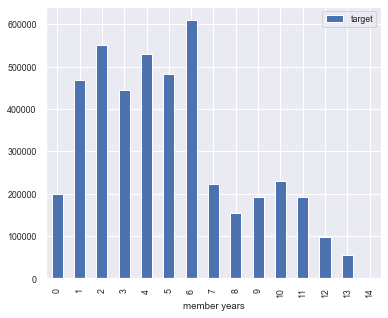

In [40]:
gender_repeat[['years_label', 'target']].groupby('years_label').count().plot.bar()
plt.xlabel('member years')
plt.show()

The feature member_days represents how long users have paid for the membership. According to the chart, new member which has 1-6 year membership are most likely to repeat the song. This teature is a kind of refelction of user income, it indicates the success rate of different income group.

## Data Wrangling 

In [41]:

import pandas as pd
import numpy as np


def convert_TF(var):
    return float(1.0) if var=='male' else float(0.0)

def convert_Found(var):
    return float(1.0) if var=='Found' else float(0.0)

  
def convert_ProductCD(var):
    if var=='C': value=float(1.0)
    if var=='H': value=float(2.0)
    if var=='R': value=float(3.0)
    if var=='S': value=float(4.0)
    return value


### Processing the null values

In [42]:
df_source_train_pre = pd.read_csv("train.csv", engine='c',iterator=True,
                                    usecols=['msno','song_id','source_system_tab','source_type','target'])
df_source_train=df_source_train_pre.get_chunk(500000)
df_source_train.sample(frac=0.8).reset_index(drop=True)
# df_source_train.sample()
# df_source_train['index'] = df_source_train.index
print("Number of positive and negative samples before processing：")
print(df_source_train['target'].value_counts())
print("="*60)

print('Processing dataset rows and columns：')
print(df_source_train.columns)
print(df_source_train.head(1))
print("="*60)
print("Pre-empty value")
print(df_source_train.isnull().sum())

Number of positive and negative samples before processing：
1    362867
0    137133
Name: target, dtype: int64
Processing dataset rows and columns：
Index(['msno', 'song_id', 'source_system_tab', 'source_type', 'target'], dtype='object')
                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   

       source_type  target  
0  online-playlist       1  
Pre-empty value
msno                    0
song_id                 0
source_system_tab    1412
source_type          1067
target                  0
dtype: int64


<br> * Train,Son, Test is a type of table that needs to be associated with other tables because it has an ID.
<br> If the ID is unique, otherwise the cartesian product will appear, and after this association, the number of rows will explode.

In [43]:
print("="*60)
df_source_train=df_source_train.dropna(axis=0)
#Processing null in source_system_tab
df_source_train=df_source_train[df_source_train['source_system_tab']!='null']

print("Post-empty value")
print("{}Non-numeric type of field：".format("train.csv"))
for col in df_source_train.columns:
    if str(df_source_train[col].dtype) == 'object':
        print(col)
        print(df_source_train.groupby(col).size())
        print("="*60)

print(df_source_train.isnull().sum())
print("="*60)


Post-empty value
train.csvNon-numeric type of field：
msno
msno
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=     76
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=      1
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=     22
+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=      3
+0+XaewkS3za58vHwKCVGwRYRvjig4lTtKDV/tOkzbU=     22
+0B4aHABar5ltaWDG4M6KCzNxpD6wnsvZpvh+o9KgtE=     21
+0U8n45rrg6b5WCy3wpqOUYCwZyLqecr3lux9K6ahMk=    125
+0e12C+p9dzDbOvKjt8eElKH9yZPshAstxjm60XFgSM=     28
+1a0wTElsAMdYysWZk1uBxeLnjxIc4vB2EznisNlpVw=     17
+2XBp2p9atTpyVPWac3SEEW41i8Xrnl7Utl/h8T4iOo=     89
+2dukLzY+E4IVHMJPFcjBu21pcSArwiZyWG2w5rGUoI=     96
+3RfkckBHS0oQrrjJj7p69bdwJak+qzKq0fhFaeXUxA=    129
+3ZfWe/LGkLA8mmHNP6eKQdwLrREb4E62en8GaCb19E=     10
+45CbJ0FesVNGJOY36mrrXFm1tkHwNyebp6qAXEc/Go=      3
+47I9cb7nrGOTd//sIc9prH7SEXA3ujNaL+1R5e1Hyo=     47
+4YtW0s/lumpkhrdTNo5ErDKsWoXCndazu97upyKuj8=      3
+4xaTltGXsNattBO89s5blOroev2V5i1M1kP0ZJpkyA=     86
+4yiZ/usBfNb5DbUfDRue4QFUye6FUtBr8wxJGIXljU=     19
+

### The following handles the member table

In [44]:
df_source_member_pre = pd.read_csv("members.csv", engine='c',iterator=True,
                                    usecols=['msno','city','bd','gender','registered_via','registration_init_time','expiration_date'])
df_source_member=df_source_member_pre.get_chunk(30000)
df_source_member.sample(frac=1.0).reset_index(drop=True)


print('Processing dataset rows and columns：')
print(df_source_member.columns)
print(df_source_member.head(1))

print("Pre-empty value")
print(df_source_member.isnull().sum())
       


print("="*60)

df_source_member=df_source_member[df_source_member['bd']>0]
df_source_member=df_source_member.dropna(axis=0)
df_source_member['gender']=df_source_member['gender'].apply(convert_TF)

print("Processed data")
print(df_source_member.isnull().sum())
print("="*60)

print("{}Non-numeric type of field：".format("members.csv"))
for col in df_source_member.columns:
    print(col,df_source_member[col].dtype)
    print(df_source_member.groupby(col).size())
    print('------------------------------')

Processing dataset rows and columns：
Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date'],
      dtype='object')
                                           msno  city  bd gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=     1   0    NaN   

   registered_via  registration_init_time  expiration_date  
0               7                20110820         20170920  
Pre-empty value
msno                          0
city                          0
bd                            0
gender                    17364
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64
Processed data
msno                      0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
dtype: int64
members.csvNon-numeric type of field：
msno object
msno
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8syw

In [45]:
import pandas as pd
import numpy as np


def convert_TF(var):
    return float(1.0) if var=='male' else float(0.0)

def convert_Found(var):
    return float(1.0) if var=='Found' else float(0.0)

  
def convert_ProductCD(var):
    if var=='C': value=float(1.0)
    if var=='H': value=float(2.0)
    if var=='R': value=float(3.0)
    if var=='S': value=float(4.0)
    return value

df_source_train_pre = pd.read_csv("train.csv", engine='c',iterator=True,
                                    usecols=['msno','song_id','source_system_tab','source_type','target'])
df_source_train=df_source_train_pre.get_chunk(500000)
df_source_train.sample(frac=0.8).reset_index(drop=True)
 
    
print("Number of positive and negative samples before processing：")
print(df_source_train['target'].value_counts())
print("="*60)

print('Processing dataset rows and columns：')
print(df_source_train.columns)
print(df_source_train.head(1))
print("="*60)
print("Pre-empty value")
print(df_source_train.isnull().sum())


#Processing null values
df_source_train=df_source_train.dropna(axis=0)


Number of positive and negative samples before processing：
1    362867
0    137133
Name: target, dtype: int64
Processing dataset rows and columns：
Index(['msno', 'song_id', 'source_system_tab', 'source_type', 'target'], dtype='object')
                                           msno  \
0  FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=   

                                        song_id source_system_tab  \
0  BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=           explore   

       source_type  target  
0  online-playlist       1  
Pre-empty value
msno                    0
song_id                 0
source_system_tab    1412
source_type          1067
target                  0
dtype: int64


<br> * The first file, this is big, and there is that flag in its content. We have to guarantee that the data we get is relatively random.

### Processing song_extra_info

In [46]:
df_source_song_extra_pre = pd.read_csv("song_extra_info.csv", engine='c',iterator=True,
                                    usecols=['song_id', 'isrc'])
df_source_song_extra=df_source_song_extra_pre.get_chunk(500000)
df_source_song_extra.sample(frac=0.8).reset_index(drop=True)

print('Processing dataset rows and columns：')
print(df_source_song_extra.columns)
print(df_source_song_extra.head(1))
print("="*60)
print("Pre-empty value")
print(df_source_song_extra.isnull().sum())
       
print("="*60)

df_source_song_extra=df_source_song_extra.dropna(axis=0)

print("emptied value")
print(df_source_song_extra.isnull().sum())
print("="*60)

print("{}Non-numeric type of field：".format("song_extra_info.csv"))
for col in df_source_song_extra.columns:
    print(col,df_source_song_extra[col].dtype)
    print(df_source_song_extra.groupby(col).size())
    print("="*60)
    # if str(df_source_song_extra[col].dtype) = 'object':


Processing dataset rows and columns：
Index(['song_id', 'isrc'], dtype='object')
                                        song_id          isrc
0  LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=  TWUM71200043
Pre-empty value
song_id        0
isrc       52840
dtype: int64
emptied value
song_id    0
isrc       0
dtype: int64
song_extra_info.csvNon-numeric type of field：
song_id object
song_id
+++2AEoM0d8iZTdbnAjUm35bnGKGMXdZJSv4rrWK6JQ=    1
+++8rHstUwViVYBaoDGkJ9pP6VzUUoe3O4MYrYyl+ic=    1
+++Fd0Am8bepnisJfuslMl4H807OyvAr55Uh1iVEJJ0=    1
+++KRMUSVSN8M1f2WM3OSC9M9nOtAypMC2FjzxKu36o=    1
+++h+5duCZJCdMuRXGljTJulLRHzt3d5TsBDXT2qyBM=    1
++/ACCkEN/+VtgrJxEqeRgRmV4y8pcarDJ9T/yRAi1E=    1
++/RNVzfI7UEqXfun6ctkyCRH+vXuL/uFobPzwvVGic=    1
++/vZqI+46GVDjrla8AU7aHZQ8wsTwRZ4NEsddF/duo=    1
++0/C0//H5TmeP+8a9/j5L2FUovW/Rtvkg/+PnI0lQE=    1
++0NpaHAQR4MMz6WuQ4ygU/rz3hECOkSupn/DgkruFo=    1
++3EFycArFQQTk7kanK6C8sM7YFz+dYGEVUdWOaKI6Y=    1
++4/NK5qpbTZWln/6UmykB8cLfRTCCj8E36IKZVzBjM=    1
++44jIRr6nW

<br> * Handling null in source_system_tab
<br> * Delete the isrc hollow value, the original document is written like this, isrc can be used as the id of the song, but there may be duplicates, one song corresponds to multiple isrc so it does not move first.

In [47]:
df_source_train=df_source_train[df_source_train['source_system_tab']!='null']


print("emptied value")
print("{}Non-numeric type of field：".format("train.csv"))
for col in df_source_train.columns:
    if str(df_source_train[col].dtype) == 'object':
        print(col)
        print(df_source_train.groupby(col).size())
        print("="*60)

print(df_source_train.isnull().sum())
print("="*60)





emptied value
train.csvNon-numeric type of field：
msno
msno
++AH7m/EQ4iKe6wSlfO/xXAJx50p+fCeTyF90GoE9Pg=     76
++e+jsxuQ8UEnmW40od9Rq3rW7+wAum4wooXyZTKJpk=      1
+/SKX44s4ryWQzYzuV7ZKMXqIKQMN1cPz3M8CJ8CFKU=     22
+/UwoUi5+rNj/F6RO6gMrMhOy0oTzs90MWKVNZs4+Wg=      3
+0+XaewkS3za58vHwKCVGwRYRvjig4lTtKDV/tOkzbU=     22
+0B4aHABar5ltaWDG4M6KCzNxpD6wnsvZpvh+o9KgtE=     21
+0U8n45rrg6b5WCy3wpqOUYCwZyLqecr3lux9K6ahMk=    125
+0e12C+p9dzDbOvKjt8eElKH9yZPshAstxjm60XFgSM=     28
+1a0wTElsAMdYysWZk1uBxeLnjxIc4vB2EznisNlpVw=     17
+2XBp2p9atTpyVPWac3SEEW41i8Xrnl7Utl/h8T4iOo=     89
+2dukLzY+E4IVHMJPFcjBu21pcSArwiZyWG2w5rGUoI=     96
+3RfkckBHS0oQrrjJj7p69bdwJak+qzKq0fhFaeXUxA=    129
+3ZfWe/LGkLA8mmHNP6eKQdwLrREb4E62en8GaCb19E=     10
+45CbJ0FesVNGJOY36mrrXFm1tkHwNyebp6qAXEc/Go=      3
+47I9cb7nrGOTd//sIc9prH7SEXA3ujNaL+1R5e1Hyo=     47
+4YtW0s/lumpkhrdTNo5ErDKsWoXCndazu97upyKuj8=      3
+4xaTltGXsNattBO89s5blOroev2V5i1M1kP0ZJpkyA=     86
+4yiZ/usBfNb5DbUfDRue4QFUye6FUtBr8wxJGIXljU=     19
+50b

### The following is processing dataset named members


In [48]:
df_source_member_pre = pd.read_csv("members.csv", engine='c',iterator=True,
                                    usecols=['msno','city','bd','gender','registered_via','registration_init_time','expiration_date'])
df_source_member=df_source_member_pre.get_chunk(30000)
df_source_member.sample(frac=1.0).reset_index(drop=True)

print('Processing dataset rows and columns：')
print(df_source_member.columns)
print(df_source_member.head(1))
print("="*60)
print("Pre-empty value: ")
print(df_source_member.isnull().sum())
 
print("="*60)

df_source_member=df_source_member[df_source_member['bd']>0]
df_source_member=df_source_member.dropna(axis=0)
df_source_member['gender']=df_source_member['gender'].apply(convert_TF)

print("emptied value")
print(df_source_member.isnull().sum())
print("="*60)

print("{}Non-numeric type of field：".format("members.csv"))
for col in df_source_member.columns:
    print(col,df_source_member[col].dtype)
    print(df_source_member.groupby(col).size())
    print('------------------------------')
    # if str(df_source_member[col].dtype) = 'object':

Processing dataset rows and columns：
Index(['msno', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'expiration_date'],
      dtype='object')
                                           msno  city  bd gender  \
0  XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=     1   0    NaN   

   registered_via  registration_init_time  expiration_date  
0               7                20110820         20170920  
Pre-empty value: 
msno                          0
city                          0
bd                            0
gender                    17364
registered_via                0
registration_init_time        0
expiration_date               0
dtype: int64
emptied value
msno                      0
city                      0
bd                        0
gender                    0
registered_via            0
registration_init_time    0
expiration_date           0
dtype: int64
members.csvNon-numeric type of field：
msno object
msno
++5wYjoMgQHoRuD3GbbvmphZbBBwymzv5Q4l8sy

### Processing dataset named song

In [49]:
df_source_song_pre = pd.read_csv("songs.csv", engine='c',iterator=True,
                                    usecols=['song_id','song_length','genre_ids','language'])
df_source_song=df_source_song_pre.get_chunk(500000)
df_source_song.sample(frac=0.8).reset_index(drop=True)

print('Processing dataset rows and columns：')
print(df_source_song.columns)
print(df_source_song.head)
print("="*60)
print("emptied value")
print(df_source_song.isnull().sum())
       

print("="*60)


df_source_song=df_source_song.dropna(axis=0)
df_source_song=df_source_song[df_source_song['language']>0]

df_source_song_temp=df_source_song[df_source_song['genre_ids'].str.contains('\|')]

df_source_song_temp=df_source_song_temp.drop(['genre_ids'], axis=1).join(df_source_song_temp['genre_ids'].str.split('|', \
                          expand=True).stack().reset_index(level=1, drop=True).rename('genre_ids'))

df_source_song=df_source_song[~df_source_song['genre_ids'].str.contains('\|')]
df_source_song=df_source_song.append(df_source_song_temp)


print("Processed data")
print(df_source_song.isnull().sum())
print("="*60)

print("{}Non-numeric type of field：".format("songs.csv"))
for col in df_source_song.columns:
    print(col,df_source_song[col].dtype)
    print(df_source_song.groupby(col).size())
    print("="*60)
    # if str(df_source_song[col].dtype) = 'object':

df_source_song_last=pd.merge(df_source_song, df_source_song_extra, on='song_id',how='inner')  # 

print('Final dataset rows and columns：')
print(df_source_song_last.shape)

print(df_source_song_last.head())


Processing dataset rows and columns：
Index(['song_id', 'song_length', 'genre_ids', 'language'], dtype='object')
<bound method NDFrame.head of                                              song_id  song_length  \
0       CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=       247640   
1       o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=       197328   
2       DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=       231781   
3       dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=       273554   
4       W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=       140329   
5       kKJ2JNU5h8rphyW21ovC+RZU+yEHPM+3w85J37p7vEQ=       235520   
6       N9vbanw7BSMoUgdfJlgX1aZPE1XZg8OS1wf88AQEcMc=       226220   
7       GsCpr618xfveHYJdo+E5SybrpR906tsjLMeKyrCNw8s=       276793   
8       oTi7oINPX+rxoGp+3O6llSltQTl80jDqHoULfRoLcG4=       228623   
9       btcG03OHY3GNKWccPP0auvtSbhxog/kllIIOx5grE/k=       232629   
10      HulM/OaHgD5kUyjNQjDUf8VZdsy7h4EJUIff79Cifwo=       272544   
11      wypPzqFNdUJAqyBVxmFGaK

<br> * ~ fetch back, then backinsert, so that the order changes, but the content barely changes, the number of lines changes

<br> * Delete the isrc hollow value, the original document is written like this, isrc can be used as the id of the song, but there may be duplicates, one song corresponds to multiple isrc so it does not move first.
<br> * First select genre_ids containing | and then remove it from the original data.

### Try to combain song_last and train

In [50]:
df_source1=pd.merge(df_source_train, df_source_member, on='msno',how='inner')
df_source=pd.merge(df_source1, df_source_song_last, on='song_id',how='inner')
# del(df_source_left,df_source_train_modify)
# del(df_source_left,df_source_train_modify)
print('Final dataset rows and columns：')
print(df_source.shape)

from sklearn.preprocessing import LabelEncoder
one_source_type1=LabelEncoder().fit(df_source['source_type']) 
one_source_type2=one_source_type1.transform(df_source['source_type']) 

one_source_type3=pd.DataFrame(one_source_type2,columns=['source_type'])
df_source=df_source.drop(['source_type'],axis=1)
df_source=pd.concat([df_source,one_source_type3],axis=1)

one_source_system_tab1=LabelEncoder().fit(df_source['source_system_tab']) 
one_source_system_tab2=one_source_system_tab1.transform(df_source['source_system_tab']) 
one_source_system_tab3=pd.DataFrame(one_source_system_tab2,columns=['source_system_tab'])
df_source=df_source.drop(['source_system_tab'],axis=1)
df_source=pd.concat([df_source,one_source_system_tab3],axis=1)

one_isrc1=LabelEncoder().fit(df_source['isrc']) 
one_isrc2=one_isrc1.transform(df_source['isrc']) 
one_isrc3=pd.DataFrame(one_isrc2,columns=['isrc'])
df_source=df_source.drop(['isrc'],axis=1)
df_source=pd.concat([df_source,one_isrc3],axis=1)


df_source=df_source.drop(['msno','song_id'],axis=1)
df_source['genre_ids']=df_source['genre_ids'].astype(int)
print(df_source.head())
print("="*60)

print("The number of positive and negative samples：")
print(df_source['target'].value_counts())
print(df_source.shape)


Final dataset rows and columns：
(126078, 15)
   target  city  bd  gender  registered_via  registration_init_time  \
0       1    13  24     0.0               9                20110525   
1       1    13  24     0.0               9                20110525   
2       1    13  19     1.0               4                20151014   
3       1    22  29     1.0               4                20151115   
4       1    13  26     0.0               7                20120514   

   expiration_date  genre_ids  language  song_length  source_type  \
0         20170911       1259      52.0       225396            4   
1         20170911        458       3.0       219324            3   
2         20171209        458       3.0       219324            3   
3         20180604        458       3.0       219324            4   
4         20171119        458       3.0       219324            5   

   source_system_tab   isrc  
0                  3  17725  
1                  3  10945  
2                  3  1

## Models

### Random forest

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

y = df_source['target']
df_source = df_source.drop(['target'],axis=1)

x_train , x_test ,y_train , y_test= train_test_split(df_source, y, random_state = 0)
# del(df_source)
print("="*60)
print("x_test shape is :",x_test.shape)
print("y_test shape is :",y_test.shape)





x_test shape is : (31520, 12)
y_test shape is : (31520,)


Random Forest Model Training

In [52]:
rfc = RandomForestClassifier(min_samples_leaf = 20)
rfc.fit(x_train, y_train)



y_predict = rfc.predict(x_test)
y_predict_proba = rfc.predict_proba(x_test)
y_predict_p = y_predict_proba[:, 1]
print('predict done!')

# Reuslts

print(confusion_matrix(y_test, y_predict))
print("="*60)
print(classification_report(y_test, y_predict))
print("="*60)
print(roc_auc_score(y_test, y_predict_p))
print("="*60)

predict done!
[[ 3206  5322]
 [ 1383 21609]]
              precision    recall  f1-score   support

           0       0.70      0.38      0.49      8528
           1       0.80      0.94      0.87     22992

    accuracy                           0.79     31520
   macro avg       0.75      0.66      0.68     31520
weighted avg       0.77      0.79      0.76     31520

0.8098893664457563


<br> * To confirm the accuracy of the model, about 80%. Estimates of 0 are not particularly accurate, but estimates of 1 are.The average is going to be high, and then you don't want to deviate too much.Something like credibility.

<br> * Random Forest
<br> Random forest is to establish a decision tree through data and estimate the characteristics of the following values through the values on each child node, which is also a classification algorithm. For this data, the first is relatively large, and the second is containing more feature values. Therefore, I chose to use the random forest model to predict the value. First, random forests can perform well in large data sets and can process multiple eigenvalues. When processing data, stochastic forest model has a high degree of generalization and a fast speed. At the same time, for multi-eigenvalue data set, it can quickly find out the relationship between each eigenvalue. For all characteristic unbalanced data, the effect of equilibrium error can be achieved. Therefore, I decided to choose the characteristic random forest model.

### GBM

In [53]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import label_binarize
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)  



params = {
    'task': 'train',
    'boosting_type': 'gbdt',  # Set promotion type
    'objective': 'regression', # Objective function 
    'metric': {'l2'},  # Evaluation function
    'num_leaves': 31,   # Number of leaf nodes
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9, # Feature selection ratio
    'bagging_fraction': 0.8, # Sample sampling ratio
    'bagging_freq': 5,  # k means that bagging is performed every k iterations
    'verbose': 1 # <0 shows fatal, =0 shows error (warning), >0 displays information
}

print('Start training...')
# Train cv and train
gbm = lgb.train(params,lgb_train,num_boost_round=200,valid_sets=lgb_eval, early_stopping_rounds=500)



print('Start predicting...')

y_score = gbm.predict(x_test)

y_pred=np.array(y_score) 
y_pred[y_pred<0.5]=0
y_pred[y_pred>0.5]=1 

print('call function auc：{}'.format(roc_auc_score(y_test,y_pred)))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_predict))
print("="*60)
print(gbm.feature_name())
print (gbm.feature_importance() )
print("="*60)

Start training...
[1]	valid_0's l2: 0.194947
Training until validation scores don't improve for 500 rounds
[2]	valid_0's l2: 0.19268
[3]	valid_0's l2: 0.190721
[4]	valid_0's l2: 0.1888
[5]	valid_0's l2: 0.187074
[6]	valid_0's l2: 0.185542
[7]	valid_0's l2: 0.184153
[8]	valid_0's l2: 0.18283
[9]	valid_0's l2: 0.181689
[10]	valid_0's l2: 0.180639
[11]	valid_0's l2: 0.179631
[12]	valid_0's l2: 0.178644
[13]	valid_0's l2: 0.177834
[14]	valid_0's l2: 0.177076
[15]	valid_0's l2: 0.176276
[16]	valid_0's l2: 0.175638
[17]	valid_0's l2: 0.175047
[18]	valid_0's l2: 0.174447
[19]	valid_0's l2: 0.173858
[20]	valid_0's l2: 0.173388
[21]	valid_0's l2: 0.172937
[22]	valid_0's l2: 0.172553
[23]	valid_0's l2: 0.172161
[24]	valid_0's l2: 0.171815
[25]	valid_0's l2: 0.171514
[26]	valid_0's l2: 0.171191
[27]	valid_0's l2: 0.170821
[28]	valid_0's l2: 0.170562
[29]	valid_0's l2: 0.170255
[30]	valid_0's l2: 0.169963
[31]	valid_0's l2: 0.169709
[32]	valid_0's l2: 0.169463
[33]	valid_0's l2: 0.169276
[34]	vali

<br> * This is the eigenvalue. The smaller the eigenvalue, the bigger the influence.
<br> * Importance can represent the weight of the eigenvalues to some extent, but because the eigenvalues in this data set are subjective factors, many algorithms are needed to test whether the eigenvalues are linear, non-linear or causal, and the absolute weight of each cannot be simply determined.

<br> * LightGBM 
<br> LightGBM is a gradient framework, a distributed and efficient decision tree. It has the advantages of faster training efficiency, lower memory usage, higher accuracy, supports parallel learning, and can process large-scale data. At the same time, it has some disadvantages that we should pay attention to. The first reason is that in each iteration, the whole training data needs to be traversed several times, which requires a lot of time to train. Memory requirements are relatively high and cannot be optimized. The second reason is that the array with different indexes needs to be read every time the tree is generated, and the order of access of different features is also different, so it will cause serious problems
The lost.

### Naive Bayes

In [54]:
from sklearn.naive_bayes import GaussianNB
bayes = GaussianNB()
bayes.fit(x_train, y_train)
y_predict = bayes.predict(x_test)

print(classification_report(y_test, y_predict))
print("="*60)

              precision    recall  f1-score   support

           0       0.48      0.16      0.23      8528
           1       0.75      0.94      0.83     22992

    accuracy                           0.73     31520
   macro avg       0.61      0.55      0.53     31520
weighted avg       0.68      0.73      0.67     31520



<br> * Naïve Bayes
<br> The idea of naive bayes is simply to compute the posterior probability that the Y variable belongs to a certain category according to some prior probability. In this data set, it is to calculate the probability of the name of the song to get the calculation of the repetition of the song. Its advantages are simple and easy to understand, high learning efficiency, and some aspects can be comparable to decision tree, neural network. However, since the independent variables in this algorithm are mutually independent and assume the normality of continuous variables as the premise, the accuracy of the algorithm will be affected if the normality of some variables is not good.

### AdaBoost

In [55]:
from sklearn.ensemble import AdaBoostRegressor
abc = AdaBoostRegressor(n_estimators=50)
abc.fit(x_train,y_train)
# score = abr.score(x_test, y_test)
# In order to fix this problem up.
#raise ValueError("Mix type of y not allowed, got types %s" % ys_types)
# ValueError: Mix type of y not allowed, got types set(['binary', 'continuous'])
y_score = abc.predict(x_test)
y_pred=np.array(y_score) 
y_pred[y_pred<0.5]=0
y_pred[y_pred>0.5]=1 
print(classification_report(y_test, y_pred))
print("="*60)
print("="*60)
print("Read test set")
del df_source
df_source_test_pre = pd.read_csv("test.csv", engine='c',iterator=True,
                                    usecols=['msno','song_id','source_system_tab','source_type'])
df_source_test=df_source_test_pre.get_chunk(500000)

df_source_test.sample()
df_source_test['index'] = df_source_test.index

df_source_test=df_source_test.dropna(axis=0)
print(df_source_test.isnull().sum())
print("="*60)

df_test1=pd.merge(df_source_test, df_source_member, on='msno',how='inner')
df_test=pd.merge(df_test1, df_source_song_last, on='song_id',how='inner')

print(df_test.shape)
print(df_test.head())
print(df_test.isnull().sum())
print("="*60)
one_source_type1=LabelEncoder().fit(df_test['source_type']) 
one_source_type2=one_source_type1.transform(df_test['source_type']) 

one_source_type3=pd.DataFrame(one_source_type2,columns=['source_type'])
df_test=df_test.drop(['source_type'],axis=1)
df_test=pd.concat([df_test,one_source_type3],axis=1)

one_source_system_tab1=LabelEncoder().fit(df_test['source_system_tab'])
one_source_system_tab2=one_source_system_tab1.transform(df_test['source_system_tab']) 
one_source_system_tab3=pd.DataFrame(one_source_system_tab2,columns=['source_system_tab'])
df_test=df_test.drop(['source_system_tab'],axis=1)
df_test=pd.concat([df_test,one_source_system_tab3],axis=1)

one_isrc1=LabelEncoder().fit(df_test['isrc'])
one_isrc2=one_isrc1.transform(df_test['isrc']) 
one_isrc3=pd.DataFrame(one_isrc2,columns=['isrc'])
df_test=df_test.drop(['isrc'],axis=1)
df_test=pd.concat([df_test,one_isrc3],axis=1)

df_test=df_test.dropna(axis=0)
print(df_test.isnull().sum())

df_test['genre_ids']=df_test['genre_ids'].astype(int)

df_save=df_test.copy()
df_test=df_test.drop(['msno','song_id','index'],axis=1)
print(df_test.head())
print("="*60)

              precision    recall  f1-score   support

           0       0.61      0.17      0.27      8528
           1       0.76      0.96      0.85     22992

    accuracy                           0.75     31520
   macro avg       0.68      0.56      0.56     31520
weighted avg       0.72      0.75      0.69     31520

Read test set
msno                 0
song_id              0
source_system_tab    0
source_type          0
index                0
dtype: int64
(123316, 15)
                                           msno  \
0  1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=   
1  91GgOFj9CDFYxxqRxQBT5L7FYjborQ40TReKAqpfQrs=   
2  1a6oo/iXKatxQx4eS9zTVD+KlSVaAFbTIqVvwLC1Y0k=   
3  91GgOFj9CDFYxxqRxQBT5L7FYjborQ40TReKAqpfQrs=   
4  KvjHjUnX4XtuyRMu77RDUTt2igG31TpXfV89XcABbfI=   

                                        song_id source_system_tab  \
0  ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=             radio   
1  ztCf8thYsS4YN3GcIL/bvoxLm/T5mYBVKOO4C9NiVfQ=             radio   
2  N

<br> * The algorithm first determines how many samples there are and then assigns the same weight to each sample.Secondly, in the specific training process, if a sample point has been accurately classified, then in the construction of the next training set, its weight will be reduced;Conversely, if a sample point is not accurately classified, then its weight is increased.And so on and so on, iteration, finally all the data processing.Finally, after the training process of each weak classifier is completed, the weight of the weak classifier with low classification error rate will be increased, so that it will play a bigger decisive role in the final classification function, while the weight of the weak classifier with high classification error rate will be reduced, so that it will play a smaller decisive role in the final classification function.In other words, the smaller the final score, the greater the weight of the eigenvalue.

## Start to predict

In [56]:
y_predict = rfc.predict(df_test)
y_predict_proba = rfc.predict_proba(df_test)
y_predict_p = y_predict_proba[:, 1]

df_rfc=df_save.copy()
df_rfc['target']=y_predict_p
df_rfc.sort_values(by=['target'],ascending=False,inplace=True)
df_rfc[['index','target']].to_csv('./sample-rfc.csv',index=False)

y_score = gbm.predict(df_test)
df_gbm=df_save.copy()
df_gbm['target']=y_score
df_gbm.sort_values(by=['target'],ascending=False,inplace=True)
df_gbm[['index','target']].to_csv('./sample-gbm.csv',index=False)


y_predict = bayes.predict(df_test)
df_bayes=df_save.copy()
df_bayes['target']=y_predict
df_bayes.sort_values(by=['target'],ascending=False,inplace=True)
df_bayes[['index','target']].to_csv('./sample-bayes.csv',index=False)


y_score = abc.predict(df_test)
df_ab=df_save.copy()
df_ab['target']=y_score
df_ab.sort_values(by=['target'],ascending=False,inplace=True)
df_ab[['index','target']].to_csv('./sample-ab.csv',index=False)

## Conclusion 

<br> Finally, we calculated the probability that each element will be played repeatedly in the test set.In this project, we have used some simple models to determine whether certain songs will be played repeatedly, and what is the probability of being played at the same time. In these algorithms, we learned the characteristics of some of them, including the importance of eigenvalues. After analyzing the data, it can be seen that in some subjective eigenvalues, we cannot judge the weight of eigenvalues solely by score. Because there are many linear or non-linear relationships, causal relationships, and other relationships between them, the specific relationship between them needs to be tested with more algorithms. Moreover, by comparison, we can see that better results can be obtained through collaborative computing.